<a href="https://colab.research.google.com/github/dhawaldarji7/BoolQ/blob/main/EntailmentEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .


Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [2]:

!pip install transformers
!pip install sentencepiece
!pip install torch torchvision
!pip install pandas
!pip install numpy

     |████████████████████████████████| 1.9MB 9.1MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
     |████████████████████████████████| 3.2MB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0faaa2bde18be743fb431951b9e476ec480cdb31aa844f9d8ea469192018bed5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 9.1MB/s 


In [3]:
# Imports
import random
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW



In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device2 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#print(device2)


cuda:0


In [7]:
train_df = pd.read_csv('train_data.csv')#[:5000]
train_df= train_df[:10000]
val_df   = pd.read_csv('val_data.csv')[:10000]

In [8]:
print(train_df)
train_df = train_df.dropna()
print(train_df)
val_df = val_df.dropna()

         gold_label  ...                                          sentence2
0           neutral  ...  Product and geography are what make cream skim...
1        entailment  ...  You lose the things to the following level if ...
2        entailment  ...  A member of my team will execute your orders w...
3        entailment  ...                  This information belongs to them.
4           neutral  ...           The tennis shoes have a range of prices.
...             ...  ...                                                ...
9995        neutral  ...  Microsoft owns 60 percent of all computer-rela...
9996  contradiction  ...                                  'Wrong', I said. 
9997  contradiction  ...                                     Thanks Obama. 
9998  contradiction  ...                         I don't think that's great
9999  contradiction  ...         Their breath was invisible in the hot air.

[10000 rows x 3 columns]
         gold_label  ...                                      

In [9]:
train_df['sentence1'] = train_df['sentence1'].astype(str)
train_df['sentence2'] = train_df['sentence2'].astype(str)

In [10]:
val_df['sentence1'] = val_df['sentence1'].astype(str)
val_df['sentence2'] = val_df['sentence2'].astype(str)

In [11]:
train_df = train_df[(train_df['sentence1'].str.split().str.len() > 0) & (train_df['sentence2'].str.split().str.len() > 0)]
val_df = val_df[(val_df['sentence1'].str.split().str.len() > 0) & (val_df['sentence2'].str.split().str.len() > 0)]

In [12]:
len(train_df)

9998

In [13]:
len(val_df)

9812

In [14]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'entailment': 0, 'contradiction': 1, 'neutral': 2}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    # Saving takes too much RAM
    #
    # if os.path.exists(os.path.join(self.base_path, 'train_data.pkl')):
    #   print("Found training data")
    #   with open(os.path.join(self.base_path, 'train_data.pkl'), 'rb') as f:
    #     self.train_data = pickle.load(f)
    # else:
    #   self.train_data = self.load_data(self.train_df)
    #   with open(os.path.join(self.base_path, 'train_data.pkl'), 'wb') as f:
    #     pickle.dump(self.train_data, f)
    # if os.path.exists(os.path.join(self.base_path, 'val_data.pkl')):
    #   print("Found val data")
    #   with open(os.path.join(self.base_path, 'val_data.pkl'), 'rb') as f:
    #     self.val_data = pickle.load(f)
    # else:
    #   self.val_data = self.load_data(self.val_df)
    #   with open(os.path.join(self.base_path, 'val_data.pkl'), 'wb') as f:
    #     pickle.dump(self.val_data, f)
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['sentence1'].to_list()
    hypothesis_list = df['sentence2'].to_list()
    label_list = df['gold_label'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

In [15]:
mnli_dataset = MNLIDataBert(train_df, val_df)


9998
9812


In [16]:
train_loader, val_loader = mnli_dataset.get_data_loaders(batch_size=16)

In [17]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [21]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

In [22]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,484,547 trainable parameters


In [23]:
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc


In [24]:
import time
from tqdm import tqdm
EPOCHS = 1

def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for _ in tqdm(range(EPOCHS), desc="Epoch"):
  #for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # prediction = model(pair_token_ids, mask_ids, seg_ids)
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      # loss = criterion(prediction, labels)
      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        # prediction = model(pair_token_ids, mask_ids, seg_ids)
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        # loss = criterion(prediction, labels)
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {EPOCHS-1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [25]:

train(model, train_loader, val_loader, optimizer)

Epoch: 100%|██████████| 1/1 [09:37<00:00, 577.27s/it]

Epoch 0: train_loss: 1.0102 train_acc: 0.4745 | val_loss: 0.8198 val_acc: 0.6561
00:09:37.26


In [26]:
print(val_loader)

In [28]:



news_article = """President Joe Biden signed the $1.9 trillion coronavirus relief package Thursday afternoon as Washington moves to send fresh aid this month. With his signature, the president checks off his first priority in the White House. He also will give a prime-time address Thursday describing how the country will proceed in fighting the virus a year after the World Health Organization declared it a pandemic."""
 

news_questions = [
"Did President Joe Biden sign 22 million coronavirus relief package",
"Did President Joe Biden sign $1.9 trillion coronavirus relief package",
"Cinco de Mayo is celebrated on 5th of may"
]




def predict_NLI(cur_question,passage_superbowl):

  new_frame = {'sentence1': [passage_superbowl], 'sentence2': [cur_question],'gold_label': "entailment"}
  new_df = pd.DataFrame(data = new_frame,index=[0])
  #print(new_df)
  new_df['sentence1'] = new_df['sentence1'].astype(str)
  new_df['sentence2'] = new_df['sentence2'].astype(str)
  new_df = new_df[(new_df['sentence1'].str.split().str.len() > 0) & (new_df['sentence2'].str.split().str.len() > 0)]
  #print(new_df)
  my_MNLI_df = MNLIDataBert(new_df,new_df)
  train_df_loader, val_df_loader = my_MNLI_df.get_data_loaders(batch_size=16)
  with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_df_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        # prediction = model(pair_token_ids, mask_ids, seg_ids)
        loss, predictions = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        print("Loss: ",loss)
        #cpu_pred = cpu().predictions
        print("pred: ", predictions.argmax().item())
        return_var = predictions.argmax().item()
        # loss = criterion(prediction, labels)
        acc = multi_acc(predictions, labels)

        #total_val_loss += loss.item()
        #total_val_acc  += acc.item()
      
  return return_var



for i in news_questions:
  predict_NLI(i, news_article)

1
1
Loss:  tensor(1.2810, device='cuda:0')
pred:  1
1
1
Loss:  tensor(0.3976, device='cuda:0')
pred:  0
1
1
Loss:  tensor(1.9982, device='cuda:0')
pred:  2


In [62]:
new_df['sentence1'] = new_df['sentence1'].astype(str)
new_df['sentence2'] = new_df['sentence2'].astype(str)

NameError: ignored

In [ ]:

new_df = new_df[(new_df['sentence1'].str.split().str.len() > 0) & (new_df['sentence2'].str.split().str.len() > 0)]

In [ ]:
print(new_df)

                                           sentence1  ...  gold_label
0  Super Bowl 50 was an American football game to...  ...  entailment

[1 rows x 3 columns]


In [ ]:
my_MNLI_df = MNLIDataBert(new_df,new_df)

1
1


In [ ]:
train_df_loader, val_df_loader = my_MNLI_df.get_data_loaders(batch_size=16)

NameError: ignored

In [ ]:
import numpy as np

with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_df_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        # prediction = model(pair_token_ids, mask_ids, seg_ids)
        loss, predictions = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        print("Loss: ",loss)
        #cpu_pred = cpu().predictions
        print("pred: ", predictions.argmax().item())
        # loss = criterion(prediction, labels)
        acc = multi_acc(predictions, labels)

        #total_val_loss += loss.item()
        #total_val_acc  += acc.item()

Loss:  tensor(0.7271, device='cuda:0')
pred:  0


In [30]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]
        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
train_data_df = pd.read_json("/content/train.jsonl", lines=True, orient='records')

#--------------------------------------------------------------------------------
#print(f"Train Data passage length: {len(train_data_df.question)}")
#print(train_data_df.passage[4643])
'''
train_data_len = min(len(train_data_df.passage),128)
for iter in range(0,train_data_len-1):
  #print("train iter : ", iter)
  drop_list = []
  cur_passage = train_data_df.passage[iter]
  #print("cur passage len : ",len(cur_passage))
  sent = ""
  cur_sent = ""
  for iter2 in range(0,len(cur_passage)):
    cur_sent = cur_sent + cur_passage[iter2]
    if iter2==len(cur_passage)-1:
        if predict_NLI(train_data_df.question[iter], cur_sent)==0 or predict_NLI(train_data_df.question[iter], cur_sent)==2 : #Here put the condition if the question and sentence entails.
          # if entailed -> append to sentence
          sent = sent + cur_sent
          cur_sent = ""
        else: # Here put the condition if they don't entail. 
          # if not -> remove it
          cur_sent = ""
          #sent = sent + cur_sent
   
    if cur_passage[iter2]=='.' and iter2!=len(cur_passage)-1 :
      # Call the entailment here and decide whether to entail or not.
      # train_data_df.question[iter] with train_data_df.passage[iter].
      #if predict_NLI(train_data_df.question[iter], passage_superbowl)==0 or predict_NLI(train_data_df.question[iter], passage_superbowl)==2 : #Here put the condition if the question and sentence entails.
      # if entailed -> append to sentence
 
      temp_var =predict_NLI(train_data_df.question[iter], cur_sent)

      if temp_var==0 or temp_var==2:
        sent = sent + cur_sent
        cur_sent = ""
      else: # Here put the condition if they don't entail. 
      # if not -> remove it
        cur_sent = ""
    
  if sent == "":
    # at the end check if sent is empty then drop this line item all together.
    drop_list.append(iter)
  if len(sent)!=len(cur_passage):
    print("Lengths do NOT match in train!",len(sent),len(cur_passage),iter)

  # Now remove droplist from the df.
  #for iter in drop_list:
  #print("Drop_list[iter] train : ",iter)
  #train_data_df = train_data_df.drop([train_data_df.index[iter for iter in drop_list]]) 
'''      
#--------------------------------------------------------------------------------      

dev_data_df = pd.read_json("/content/dev.jsonl", lines=True, orient="records")[:50]
#print(f"Dev Data passage length: {len(dev_data_df.question)}")

dev_data_len = min(len(dev_data_df.passage),128)
for iter in range(0,dev_data_len-1):
  #print("dev iter : ", iter)
  drop_list = []
  cur_passage = dev_data_df.passage[iter]
  #print("cur passage len : ",len(cur_passage))
  sent = ""
  cur_sent = ""
  for iter2 in range(0,len(cur_passage)):
    cur_sent = cur_sent + cur_passage[iter2]
    if iter2==len(cur_passage)-1:
      
        if predict_NLI(dev_data_df.question[iter], cur_sent)==1 or predict_NLI(dev_data_df.question[iter], cur_sent)==0 : #Here put the condition if the question and sentence entails.
      # if entailed -> append to sentence
          sent = sent + cur_sent
          cur_sent = ""
        else: # Here put the condition if they don't entail. 
          # if not -> remove it
          cur_sent = ""
          #sent = sent + cur_sent
    if cur_passage[iter2]=='.' and iter2!=len(cur_passage)-1 :
      # Call the entailment here and decide whether to entail or not.
      # dev_data_df.question[iter] with dev_data_df.passage[iter].
      if predict_NLI(dev_data_df.question[iter], cur_sent)==1 or predict_NLI(dev_data_df.question[iter], cur_sent)==0 : #Here put the condition if the question and sentence entails.
      # if entailed -> append to sentence
        sent = sent + cur_sent
        cur_sent = ""
      else: # Here put the condition if they don't entail. 
      # if not -> remove it
        cur_sent = ""
    
  if sent == "":
    sent = "[MASK]"
    # at the end check if sent is empty then drop this line item all together.
    drop_list.append(iter)
    print("DANGER ZONE ! DANGER ZONE!~")
  if len(sent)!=len(cur_passage):
    print("Lengths do NOT match in dev!",len(sent),len(cur_passage),iter)

  # Now remove droplist from the df.
  #for iter in drop_list:
   # print("Drop_list[iter] test: ",iter)
    #dev_data_df = dev_data_df.drop([dev_data_df.index[iter]]) 
    #drop_list = drop_list - 1    















passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)



1
1
Loss:  tensor(1.6623, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.6623, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.9829, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.9829, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.0082, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.0082, device='cuda:0')
pred:  2
1
1
Loss:  tensor(0.8045, device='cuda:0')
pred:  0
1
1
Loss:  tensor(0.8045, device='cuda:0')
pred:  0
1
1
Loss:  tensor(1.0927, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.0927, device='cuda:0')
pred:  2
1
1
Loss:  tensor(0.4845, device='cuda:0')
pred:  0
1
1
Loss:  tensor(0.4845, device='cuda:0')
pred:  0
1
1
Loss:  tensor(1.9124, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.9124, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.0753, device='cuda:0')
pred:  1
1
1
Loss:  tensor(1.7140, device='cuda:0')
pred:  2
1
1
Loss:  tensor(1.7140, device='cuda:0')
pred:  2
1
1
Loss:  tensor(0.4815, device='cuda:0')
pred:  0
1
1
Loss:  tensor(0.4815, device='cuda:0')
pred:  0
Lengths do N

In [31]:
# Integration Part-2

# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA?:",torch.cuda.is_available())
# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model.to(device) # Send the model to the GPU if we have one

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)


# Encoding data
max_seq_length = 128
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

CUDA?: True


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [32]:
from sklearn.metrics import f1_score  
def F1_sklearn_method(gt,pred):
  print("Gt" ,gt)
  print("pred",pred)
  return f1_score(gt, pred, average='binary')

def F1_my_method(ground_truth, predictions):
  g_val = np.asarray(ground_truth)
  p_val = np.asarray(predictions)
  sum_g_p = g_val+p_val
  sum_g_p = sum_g_p==2
  TP = np.sum(np.where(sum_g_p==True,1,0))
  g_neg = 1-g_val
  p_neg = 1-p_val
  sum_g_p_neg = g_neg + p_neg
  sum_g_p_neg = sum_g_p_neg == 2
  TN = np.sum(np.where(sum_g_p_neg==True,1,0))
  dif_g_p = g_val-p_val
  FN = np.sum(np.where(dif_g_p==1,dif_g_p,0))
  FP = np.abs(np.sum(np.where(dif_g_p==-1,dif_g_p,0)))
  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)
  F1 = 2*Precision*Recall/(Precision+Recall)
  return TP,TN,FN,FP,Precision,Recall,F1

# Building Dataloaders
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

epochs = 3
grad_acc_steps = 3
train_loss_values = []
dev_acc_values = []
label_set = []
predictions_set = []
f1_set = []
for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 # Cumulative accuracy
  model.eval()
  epoch_dev_F1 =0

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
                
    with torch.no_grad():        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    label_set.append(labels)
    print("labels: ", labels)
    print("predictions :",predictions)
    predictions_set.append(predictions)
    TP,TN,FN,FP,Precision,Recall,F1 = F1_my_method(labels, predictions)
    print("My F1 output:", F1)
    epoch_dev_F1 += F1
    print("Epoch_dev_F1_produced",epoch_dev_F1)
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)
  #f1_score = F1_sklearn_method(labels,predictions)
  print("DAta loader LEN : ",len(dev_dataloader))
  epoch_dev_F1 = epoch_dev_F1/(len(dev_dataloader))
  print("Epoch DEv F1:",epoch_dev_F1)
  f1_set.append(epoch_dev_F1)
  print("F1_SET:",f1_set)
  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  dev_acc_values.append(epoch_dev_accuracy)


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

labels:  [0 1 1 1 1 0 1 1]
predictions : [0 0 1 1 1 1 1 0]
My F1 output: 0.7272727272727272
Epoch_dev_F1_produced 0.7272727272727272
labels:  [1 1 1 0 1 1 1 1]
predictions : [1 1 0 1 0 1 1 0]
My F1 output: 0.6666666666666666
Epoch_dev_F1_produced 1.3939393939393938
labels:  [1 1 1 1 0 1 1 1]
predictions : [0 1 0 1 0 1 1 1]
My F1 output: 0.8333333333333333
Epoch_dev_F1_produced 2.227272727272727
labels:  [1 1 1 0 1 1 1 1]
predictions : [0 1 0 0 1 1 1 0]
My F1 output: 0.7272727272727273
Epoch_dev_F1_produced 2.954545454545454


Epoch:  33%|███▎      | 1/3 [03:50<07:41, 230.93s/it]

labels:  [0 1 1 1 0 1 0 0]
predictions : [0 0 1 1 1 1 1 0]
My F1 output: 0.6666666666666665
Epoch_dev_F1_produced 3.6212121212121207
labels:  [1 0 1 0 1 1 1 1]
predictions : [1 0 1 0 1 0 1 1]
My F1 output: 0.9090909090909091
Epoch_dev_F1_produced 4.530303030303029
labels:  [1 1]
predictions : [1 1]
My F1 output: 1.0
Epoch_dev_F1_produced 5.530303030303029
DAta loader LEN :  7
Epoch DEv F1: 0.7900432900432899
F1_SET: [0.7900432900432899]
labels:  [0 1 1 1 1 0 1 1]
predictions : [1 1 1 1 1 0 1 1]
My F1 output: 0.923076923076923
Epoch_dev_F1_produced 0.923076923076923
labels:  [1 1 1 0 1 1 1 1]
predictions : [1 1 1 0 0 1 1 1]
My F1 output: 0.923076923076923
Epoch_dev_F1_produced 1.846153846153846
labels:  [1 1 1 1 0 1 1 1]
predictions : [0 1 0 1 0 1 1 1]
My F1 output: 0.8333333333333333
Epoch_dev_F1_produced 2.6794871794871793
labels:  [1 1 1 0 1 1 1 1]
predictions : [0 1 1 0 1 1 1 1]
My F1 output: 0.923076923076923
Epoch_dev_F1_produced 3.602564102564102


Epoch:  67%|██████▋   | 2/3 [07:40<03:50, 230.60s/it]

labels:  [0 1 1 1 0 1 0 0]
predictions : [0 0 1 1 1 1 1 0]
My F1 output: 0.6666666666666665
Epoch_dev_F1_produced 4.269230769230768
labels:  [1 0 1 0 1 1 1 1]
predictions : [1 0 1 0 1 1 1 1]
My F1 output: 1.0
Epoch_dev_F1_produced 5.269230769230768
labels:  [1 1]
predictions : [1 1]
My F1 output: 1.0
Epoch_dev_F1_produced 6.269230769230768
DAta loader LEN :  7
Epoch DEv F1: 0.8956043956043954
F1_SET: [0.7900432900432899, 0.8956043956043954]


Epoch: 100%|██████████| 3/3 [11:31<00:00, 230.45s/it]

labels:  [0 1 1 1 0 1 0 0]
predictions : [0 0 1 1 1 1 1 0]
My F1 output: 0.6666666666666665
Epoch_dev_F1_produced 4.332167832167832
labels:  [1 0 1 0 1 1 1 1]
predictions : [1 1 1 0 1 0 1 1]
My F1 output: 0.8333333333333334
Epoch_dev_F1_produced 5.165501165501165
labels:  [1 1]
predictions : [1 0]
My F1 output: 0.6666666666666666
Epoch_dev_F1_produced 5.832167832167832
DAta loader LEN :  7
Epoch DEv F1: 0.833166833166833
F1_SET: [0.7900432900432899, 0.8956043956043954, 0.833166833166833]


In [33]:

for step, batch in enumerate(train_features):
  print(step, batch )
  if step==1:
    break

0 [[    0  5016 10209 ...  8907   187     2]
 [    0  5016   205 ...     7   489     2]
 [    0   354  6410 ...     1     1     1]
 ...
 [    0   354     5 ...   893  1145     2]
 [    0   417 35185 ... 19822    11     2]
 [    0   354  2759 ...     1     1     1]]
1 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]]


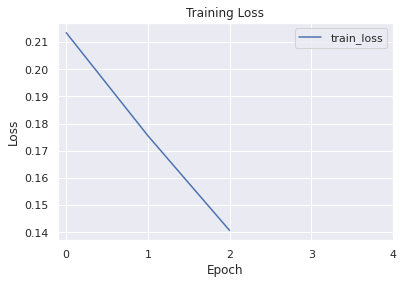

In [34]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

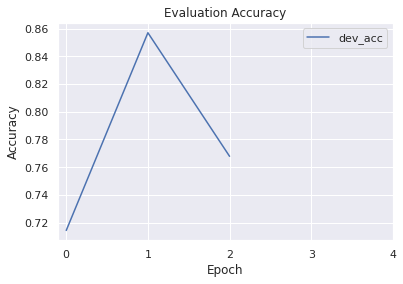

In [35]:

plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

[0.7900432900432899, 0.8956043956043954, 0.833166833166833]


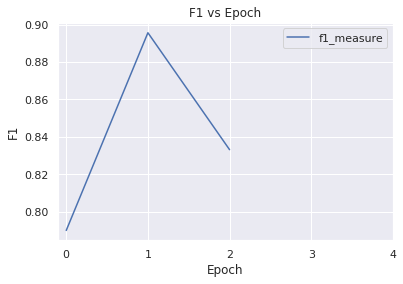

In [36]:
print(f1_set)
plt.plot(f1_set, label="f1_measure")

plt.xlabel("Epoch")
plt.ylabel("F1")
plt.title("F1 vs Epoch")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

In [37]:

def predict(question, passage):
  sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)
  
  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 2)
  proba_no = round(probabilities[0], 2)

  print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")
  
passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
                    (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
                    the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
                    The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
                    California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
                    gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
                    with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
                    prominently feature the Arabic numerals 50."""
 
passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
                  and the new means of human interaction this technology enables."""

superbowl_questions = [
"Did the Denver Broncos win the Super Bowl 50?", 
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?", 
"Was the Super Bowl 50 played in Las Vegas?", 
"Was the Super Bowl 50 played in February?", 
"Was the Super Bowl 50 played in March?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

for s_question in superbowl_questions:
  predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)

Question: Did the Denver Broncos win the Super Bowl 50?, Yes: 0.96, No: 0.04
Question: Did the Carolina Panthers win the Super Bowl 50?, Yes: 0.95, No: 0.05
Question: Was the Super Bowl played at Levi's Stadium?, Yes: 0.95, No: 0.05
Question: Was the Super Bowl 50 played in Las Vegas?, Yes: 0.43, No: 0.57
Question: Was the Super Bowl 50 played in February?, Yes: 0.96, No: 0.04
Question: Was the Super Bowl 50 played in March?, Yes: 0.49, No: 0.51
Question: Is Illuin the answer to your strategic needs?, Yes: 0.74, No: 0.26
